# Data Cleaning and Toxic Comments detection.

### Import essential packages

In [1]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *

import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline

spark = SparkSession.builder\
    .master("local[*]")\
    .config("spark.executor.memory", "128G")\
    .config("spark.driver.memory", "32G")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.4")\
    .getOrCreate()


21/12/22 18:00:02 WARN Utils: Your hostname, DESKTOP-HJJ1CNO resolves to a loopback address: 127.0.1.1; using 192.168.0.108 instead (on interface eth1)
21/12/22 18:00:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/tony/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tony/.ivy2/cache
The jars for the packages stored in: /home/tony/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-35b70d6f-0281-4d00-a3a3-4183be743d23;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.4 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1

### Read csv data

In [2]:
schema = StructType([
    StructField("vid", StringType(), True),
    StructField("text", StringType(), True),
    StructField("likes", IntegerType(), True),
])

df_comments_base = spark.read.schema(schema).format("csv").option("header",True).option("encoding", "utf-8").load("./comments.csv")
df_comments_base.show()

+-----------+--------------------+-----+
|        vid|                text|likes|
+-----------+--------------------+-----+
|HlEFrbLeDks|I&#39;m vaccine a...|    1|
|HlEFrbLeDks|Hi from the futur...|    1|
|HlEFrbLeDks|He will always be...|    0|
|HlEFrbLeDks|I remember watchi...|    0|
|HlEFrbLeDks|Introverts were l...|    4|
|HlEFrbLeDks|         Good times.|    0|
|HlEFrbLeDks|The beginning of ...|    3|
|HlEFrbLeDks|This must never h...|    0|
|HlEFrbLeDks|Watching this a y...|    2|
|HlEFrbLeDks|One year on and I...|    0|
|HlEFrbLeDks|I didnt mind stay...|    2|
|HlEFrbLeDks|Tomorrow marks on...|    3|
|HlEFrbLeDks|Can’t believe it’...|    7|
|HlEFrbLeDks|This was the wors...|    1|
|HlEFrbLeDks|here we are lockd...|    0|
|HlEFrbLeDks|The day it all we...|    5|
|HlEFrbLeDks|What happens if i...|    1|
|HlEFrbLeDks|  This is soo COOOOL|    0|
|HlEFrbLeDks|Interesting to re...|    2|
|HlEFrbLeDks|9 months later an...|    1|
+-----------+--------------------+-----+
only showing top

### Data cleaning and comments selection

In [3]:
df_comments = df_comments_base.filter(col("likes") >= 0)
df_comments = df_comments.withColumn("rank", row_number().over(Window.partitionBy(col("vid")).orderBy(desc(col("likes"))))).filter(col("rank") <= 20)
df_comments.show()

+-----------+--------------------+-----+----+
|        vid|                text|likes|rank|
+-----------+--------------------+-----+----+
|LyiUHxD3S8s|Six brain cells i...|  156|   1|
|LyiUHxD3S8s|It&#39;s not maki...|  135|   2|
|LyiUHxD3S8s|The snitches shou...|   81|   3|
|LyiUHxD3S8s|Soo everyone arou...|   78|   4|
|LyiUHxD3S8s|If you are the so...|   76|   5|
|LyiUHxD3S8s|making it up as w...|   71|   6|
|LyiUHxD3S8s|Fake news<br>Gove...|   67|   7|
|LyiUHxD3S8s|0.1% death rate o...|   47|   8|
|LyiUHxD3S8s|It&#39;s simple, ...|   39|   9|
|LyiUHxD3S8s|And Grouse shoote...|   31|  10|
|LyiUHxD3S8s|&quot;People shou...|   26|  11|
|LyiUHxD3S8s|Anyone noticed ho...|   25|  12|
|LyiUHxD3S8s|There&#39;s six o...|   24|  13|
|LyiUHxD3S8s|Bollocks to the g...|   23|  14|
|LyiUHxD3S8s|Clearly &quot;The...|   18|  15|
|LyiUHxD3S8s|make your voice h...|   15|  16|
|LyiUHxD3S8s|Unless you&#39;re...|   13|  17|
|LyiUHxD3S8s|Another power tri...|   13|  18|
|LyiUHxD3S8s|I&#39;ve got a ch...|

### Read video data

In [4]:
vschema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True)
])

df_bbc = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/BBC_videos_final.csv")
df_bbc = df_bbc.select(col("videoId"), col("year"), col("month"), col("day"))
df_bbc = df_bbc.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("BBC"))

df_guardian = spark.read.schema(vschema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/Guardian_videos_final.csv")
df_guardian = df_guardian.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_guardian = df_guardian.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Guardian"))
df_guardian.show()

+-----------+--------+--------+
|    videoId|    Date|    from|
+-----------+--------+--------+
|8bUCwmYcvzY|20200323|Guardian|
|Ml-1hUISPj8|20200323|Guardian|
|ZD4PYP6eayQ|20200324|Guardian|
|x5XT8H5PLzQ|20200329|Guardian|
|x2axKYqLXso|20200416|Guardian|
|RVHKA3BKpBo|20200416|Guardian|
|CCOnQAmbDNc|20200430|Guardian|
|Y7hYnZnSliI|20200430|Guardian|
|WRs-dC-gmVk|20200510|Guardian|
|PPhf8LfrS_c|20200510|Guardian|
|6jBur0Bu7L8|20200529|Guardian|
|df41adre86A|20200623|Guardian|
|0dBS5xEWlsI|20200623|Guardian|
|RDY8W11ROgM|20200623|Guardian|
|uqzggg3nooo|20200629|Guardian|
|GS4nRFfM_Fs|20200922|Guardian|
|u63SBuGqN6Y|20200922|Guardian|
|weANMwwcLA8|20200930|Guardian|
|yWAniPfrBDo|20200930|Guardian|
|NCy7Q6Nr4_4|20201013|Guardian|
+-----------+--------+--------+
only showing top 20 rows



In [5]:
special_schema = StructType([
    StructField("index_label", StringType(), True),
    StructField("channelId", StringType(), True),
    StructField("channelTitle", StringType(), True),
    StructField("videoId", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("day", IntegerType(), True),
    StructField("videoTitle", StringType(), True),
    StructField("description", StringType(), True),
    StructField("link", StringType(), True),
    StructField("time", StringType(), True),
])
df_dailymail = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/DailyMail_videos_final.csv")
df_dailymail = df_dailymail.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_dailymail = df_dailymail.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("DailyMail"))

df_independent = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/Independent_videos_final.csv")
df_independent = df_independent.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_independent = df_independent.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("Independent"))

df_sun = spark.read.schema(special_schema).format("csv").option("header",True).option("encoding", "utf-8").load("./final/SUN_videos_final.csv")
df_sun = df_sun.filter(col("channelId") != "na").select(col("videoId"), col("year"), col("month"), col("day")).filter(col("videoId") != "#NAME?")
df_sun = df_sun.withColumn("Date", col("year") * 10000 + col("month") * 100 + col("day")).select(col("videoId"), col("Date")).withColumn("from", lit("SUN"))
df_sun.show()

+-----------+--------+----+
|    videoId|    Date|from|
+-----------+--------+----+
|-Lfy5GcJkNk|20200320| SUN|
|FqDo_QWoqtE|20200325| SUN|
|Pu4GWu3cMec|20200325| SUN|
|iM6onBpOPUE|20200326| SUN|
|bYA3iTt0Shw|20200416| SUN|
|Cr5A7Q_MruU|20200416| SUN|
|8zGQMzs_ows|20200430| SUN|
|DmeQSrTAXac|20200430| SUN|
|TPAHsgwEvsU|20200510| SUN|
|AMRYSm54SKk|20200510| SUN|
|V1jqlU6pTE0|20200510| SUN|
|IlLrVsnLkzc|20200528| SUN|
|PMjTS-4WFLA|20200615| SUN|
|wOgc9g9iNlY|20200623| SUN|
|6LUxrhF1W38|20200629| SUN|
|NNNznC7hdho|20200629| SUN|
|TnHDev5qT-A|20200914| SUN|
|PNDC-Llff9c|20200922| SUN|
|Vufy881Y4kc|20200922| SUN|
|SW5XYszDTPE|20200930| SUN|
+-----------+--------+----+
only showing top 20 rows



### Connect comments and the video they belongs to

In [6]:
df_media = df_bbc.unionAll(df_guardian).unionAll(df_dailymail).unionAll(df_independent).unionAll(df_sun)
df_comments = df_comments.join(df_media, on = (col("videoId") == col("vid"))).select(col("text"), col("Date").alias("date"), col("from"))
df_comments.show()

+--------------------+--------+-----------+
|                text|    date|       from|
+--------------------+--------+-----------+
|Six brain cells i...|20200914|Independent|
|It&#39;s not maki...|20200914|Independent|
|The snitches shou...|20200914|Independent|
|Soo everyone arou...|20200914|Independent|
|If you are the so...|20200914|Independent|
|making it up as w...|20200914|Independent|
|Fake news<br>Gove...|20200914|Independent|
|0.1% death rate o...|20200914|Independent|
|It&#39;s simple, ...|20200914|Independent|
|And Grouse shoote...|20200914|Independent|
|&quot;People shou...|20200914|Independent|
|Anyone noticed ho...|20200914|Independent|
|There&#39;s six o...|20200914|Independent|
|Bollocks to the g...|20200914|Independent|
|Clearly &quot;The...|20200914|Independent|
|make your voice h...|20200914|Independent|
|Unless you&#39;re...|20200914|Independent|
|Another power tri...|20200914|Independent|
|I&#39;ve got a ch...|20200914|Independent|
|Blackened tongues...|20200914|I

### Toxic comments detection pipeline

In [7]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

use = UniversalSentenceEncoder.pretrained()\
    .setInputCols(["document"])\
    .setOutputCol("use_embeddings")

docClassifier = MultiClassifierDLModel.pretrained("multiclassifierdl_use_toxic")\
    .setInputCols(["use_embeddings"])\
    .setOutputCol("category")\
    .setThreshold(0.5)

pipeline = Pipeline(
    stages = [
        document,
        use,
        docClassifier
])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
Download done! Loading the resource.
[ | ]

2021-12-22 18:00:32.109376: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-22 18:00:32.331088: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3500000000 Hz


[OK!]
multiclassifierdl_use_toxic download started this may take some time.
Approximate size to download 11.6 MB
[ | ]multiclassifierdl_use_toxic download started this may take some time.
Approximate size to download 11.6 MB
Download done! Loading the resource.
[ / ]

[OK!]


In [8]:
pipeline_model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))
df_toxic = pipeline_model.transform(df_comments)
df_toxic = df_toxic.select(col("text"), col("date"), col("from"), col("category.result"))
df_toxic.show()

+--------------------+--------+-----------+-------+
|                text|    date|       from| result|
+--------------------+--------+-----------+-------+
|Six brain cells i...|20200914|Independent|[toxic]|
|It&#39;s not maki...|20200914|Independent|     []|
|The snitches shou...|20200914|Independent|     []|
|Soo everyone arou...|20200914|Independent|     []|
|If you are the so...|20200914|Independent|[toxic]|
|making it up as w...|20200914|Independent|     []|
|Fake news<br>Gove...|20200914|Independent|[toxic]|
|0.1% death rate o...|20200914|Independent|     []|
|It&#39;s simple, ...|20200914|Independent|     []|
|And Grouse shoote...|20200914|Independent|     []|
|&quot;People shou...|20200914|Independent|     []|
|Anyone noticed ho...|20200914|Independent|     []|
|There&#39;s six o...|20200914|Independent|     []|
|Bollocks to the g...|20200914|Independent|     []|
|Clearly &quot;The...|20200914|Independent|     []|
|make your voice h...|20200914|Independent|     []|
|Unless you&

In [9]:
def toxic(content):
    if len(content) > 4:
        print(content)
    if len(content[3]) > 0:
        return content
    else:
        return (content[0], content[1], content[2], None)


In [10]:
df_toxic.printSchema()
df_toxic_rdd = df_toxic.rdd.map(lambda x: toxic(x))
df_toxic = df_toxic_rdd.toDF()
df_toxic.show()

root
 |-- text: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- from: string (nullable = false)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)



+--------------------+--------+-----------+-------+
|                text|    date|       from| result|
+--------------------+--------+-----------+-------+
|Six brain cells i...|20200914|Independent|[toxic]|
|It&#39;s not maki...|20200914|Independent|   null|
|The snitches shou...|20200914|Independent|   null|
|Soo everyone arou...|20200914|Independent|   null|
|If you are the so...|20200914|Independent|[toxic]|
|making it up as w...|20200914|Independent|   null|
|Fake news<br>Gove...|20200914|Independent|[toxic]|
|0.1% death rate o...|20200914|Independent|   null|
|It&#39;s simple, ...|20200914|Independent|   null|
|And Grouse shoote...|20200914|Independent|   null|
|&quot;People shou...|20200914|Independent|   null|
|Anyone noticed ho...|20200914|Independent|   null|
|There&#39;s six o...|20200914|Independent|   null|
|Bollocks to the g...|20200914|Independent|   null|
|Clearly &quot;The...|20200914|Independent|   null|
|make your voice h...|20200914|Independent|   null|
|Unless you&

### Count toxic comments number and calculate proportion

In [11]:
df_hot_comments_total = df_toxic.groupBy("from").count().select(col("from"), col("count").alias("hot_count"))
df_hot_comments_toxic = df_toxic.filter(col("result").isNotNull()).groupBy("from").count().select(col("from"), col("count").alias("hot_toxic_count"))
df_hot_comments_toxic_ratio = df_hot_comments_total.join(df_hot_comments_toxic, on=("from")).withColumn("hot_toxic_rate", col("hot_toxic_count") / col("hot_count"))
df_hot_comments_toxic_ratio.show()

+-----------+---------+---------------+--------------------+
|       from|hot_count|hot_toxic_count|      hot_toxic_rate|
+-----------+---------+---------------+--------------------+
|  DailyMail|      338|             13|0.038461538461538464|
|   Guardian|      739|             24| 0.03247631935047361|
|        SUN|      820|             36| 0.04390243902439024|
|        BBC|      860|             40|0.046511627906976744|
|Independent|      638|             35|   0.054858934169279|
+-----------+---------+---------------+--------------------+



### Visualization using matplotlib

In [12]:
from matplotlib import pyplot as plt

In [13]:
media = df_hot_comments_toxic_ratio.select(col("from").alias("from_media")).collect()
media_x = [row.from_media for row in media]
hot_toxic_rate = df_hot_comments_toxic_ratio.select(col("hot_toxic_rate")).collect()
hot_toxic_rate_y = [row.hot_toxic_rate * 100 for row in hot_toxic_rate]
print(media_x)
print(hot_toxic_rate_y)

['DailyMail', 'Guardian', 'SUN', 'BBC', 'Independent']
[3.8461538461538463, 3.247631935047361, 4.390243902439024, 4.651162790697675, 5.4858934169279]


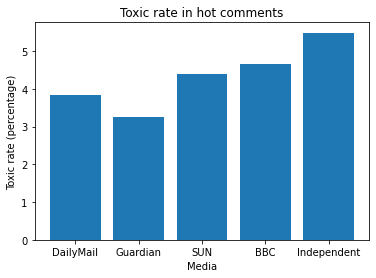

In [14]:
plt.bar(media_x, hot_toxic_rate_y, align="center")
plt.title("Toxic rate in hot comments")
plt.xlabel("Media")
plt.ylabel("Toxic rate (percentage)")
plt.show()